# 1. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import warnings
import statsmodels.api as sm

# Machine Learning & Deep Learning Libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

C:\Users\Vishw\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (16, 8)

# 2. Load Data

In [3]:
df=pd.read_csv(r"C:\Users\Vishw\OneDrive\Desktop\Data science class\Capstone2 Project\Enventory management\archive (1)\online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# 3. Data Preparation and visualization

## 3.1 Dimensions of Dataset

In [4]:
df.shape

(1067371, 8)

## 3.2 Statistical Summary

In [5]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


## 3.3 Checking for Missing Values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


## 3.4 Converting datatype

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [8]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

## 3.5 Clean Data (Remove Returns & Cancelled orders)

In [9]:
#As there are values of Quantity and Price column which are negative which represent the purchase is refunded / returned.

In [10]:
df_cleaned= df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [11]:
df_cleaned.shape

(1041671, 8)

In [12]:
df_cleaned.isnull().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    236122
Country             0
dtype: int64

In [13]:
# Check for total unique no. of products
print(f"Total Unique Products (Cleaned): {df_cleaned['StockCode'].nunique()}")

Total Unique Products (Cleaned): 4917


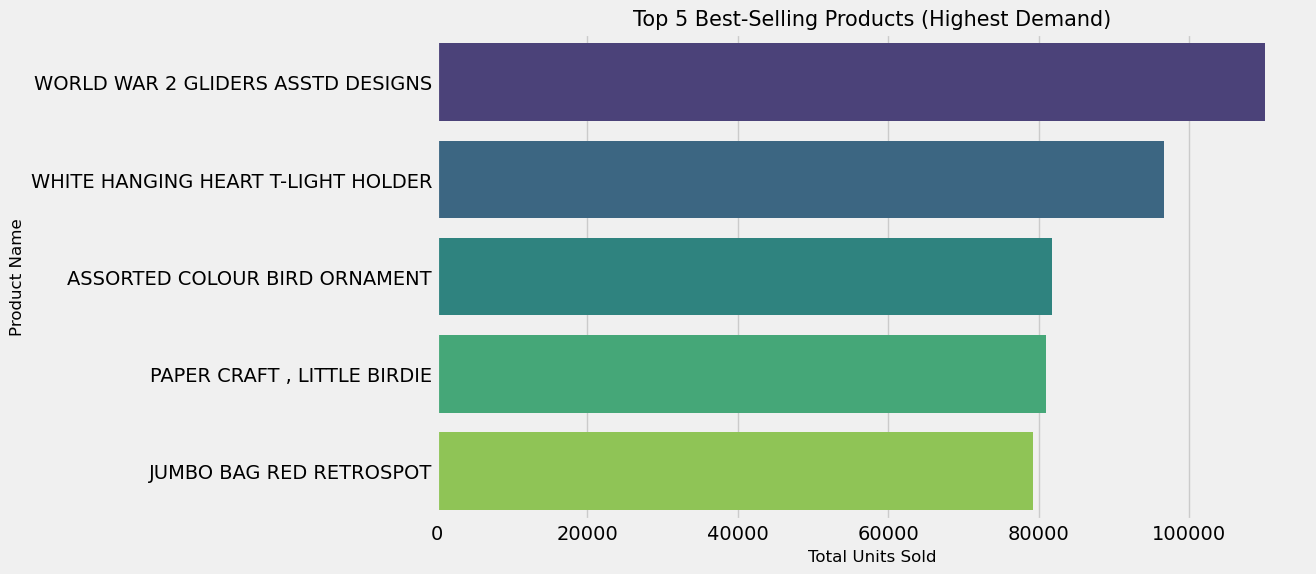

In [14]:
top_5_products = df_cleaned.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(5)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_products.values, y=top_5_products.index, palette='viridis')
plt.title('Top 5 Best-Selling Products (Highest Demand)', fontsize=15)
plt.xlabel('Total Units Sold', fontsize=12)
plt.ylabel('Product Name', fontsize=12)
plt.show()


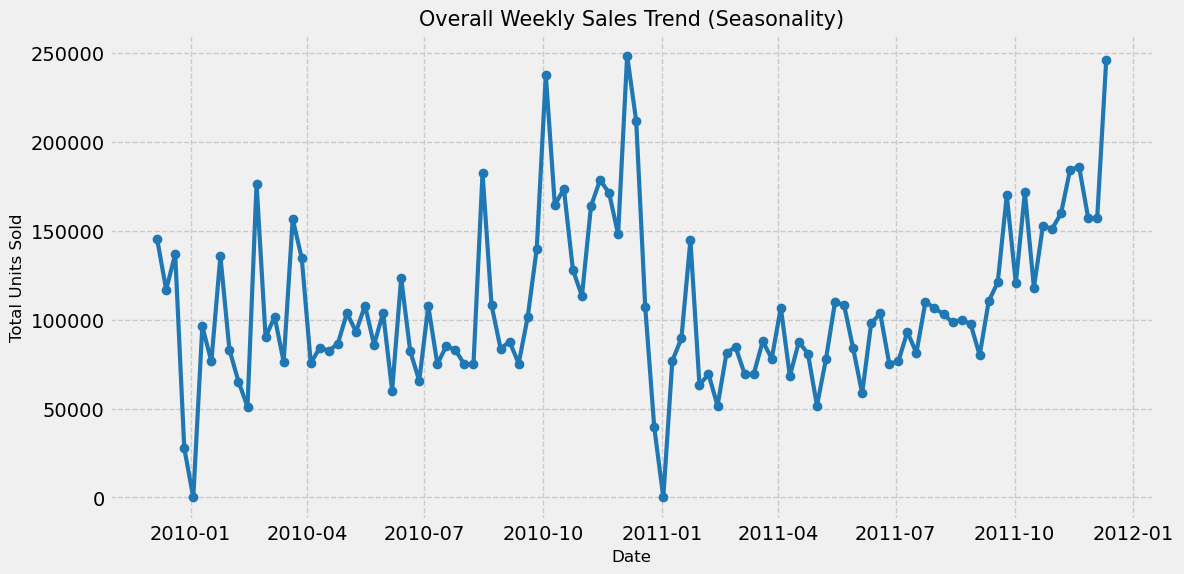

In [15]:
weekly_trend = df_cleaned.set_index('InvoiceDate')['Quantity'].resample('W').sum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(weekly_trend.index, weekly_trend.values, color='tab:blue', linewidth=3, marker='o')

plt.title('Overall Weekly Sales Trend (Seasonality)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Units Sold', fontsize=12)
plt.grid(True, linestyle='--')
plt.show()

In [16]:
#Now as there are 4917 unique products using all of there for prediction will be a alot of problem so we will use only top product for over pre

In [17]:
top_product=df_cleaned.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).index[0]

In [18]:
prod_name=df_cleaned[df_cleaned['StockCode']==top_product]['Description'].iloc[0]

In [19]:
print(f"Top Product is : {prod_name} (ID: {top_product})")

Top Product is : WORLD WAR 2 GLIDERS ASSTD DESIGNS (ID: 84077)


In [20]:
# now as we got the top product we will build model on it.

In [21]:
df_prod=df_cleaned[df_cleaned['StockCode']==top_product].copy()

In [22]:
df_prod.set_index('InvoiceDate',inplace=True)

In [23]:
df_prod.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country
InvoiceDate,,,,,,,
2009-12-01 12:57:00,489561,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,0.21,14654.0,United Kingdom
2009-12-02 10:58:00,489723,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,288,0.18,14299.0,United Kingdom
2009-12-02 12:32:00,489802,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,3,0.21,15581.0,United Kingdom
2009-12-02 13:20:00,489816,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,0.21,16086.0,United Kingdom
2009-12-02 13:23:00,489819,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,96,0.21,14739.0,United Kingdom


In [24]:
df_prod.shape

(1043, 7)

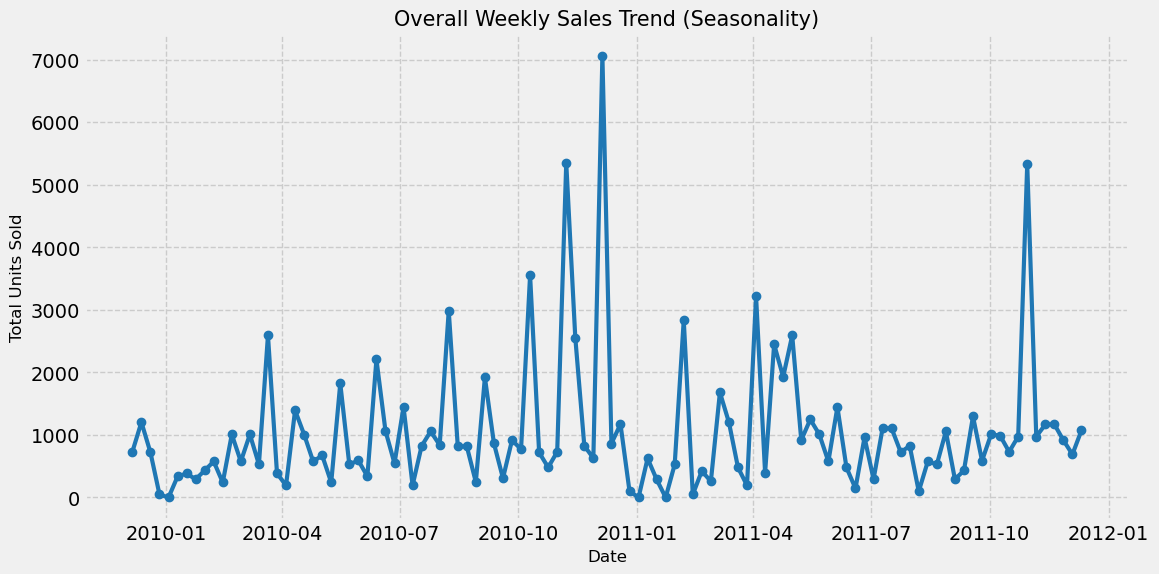

In [25]:
weekly_trend = df_prod['Quantity'].resample('W').sum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(weekly_trend.index, weekly_trend.values, color='tab:blue', linewidth=3, marker='o')

plt.title('Overall Weekly Sales Trend (Seasonality)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Units Sold', fontsize=12)
plt.grid(True, linestyle='--')
plt.show()

In [26]:
data = pd.DataFrame(df_prod['Quantity'].resample('W').sum().fillna(0))
data.columns = ['Demand']

### Scaling Data

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [28]:
#Creating lag feature(X,y) in which X will store sales of past 4 weeks and y will store sales of 5th week as a trget varaible. 

look_back = 4
X, y = [], []
for i in range(len(scaled_data) - look_back):
    X.append(scaled_data[i:(i + look_back), 0])
    Y = scaled_data[i + look_back, 0]
    y.append(Y)
X, y = np.array(X), np.array(y)

# MODEL 1 - RANDOM FOREST

In [29]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=False)

In [30]:
print('x_train shape :',x_train.shape)
print('x_test shpae :',x_test.shape)
print('y_train shape :',y_train.shape)
print('y_test shape :',y_test.shape)

x_train shape : (81, 4)
x_test shpae : (21, 4)
y_train shape : (81,)
y_test shape : (21,)


In [31]:
rf_model=RandomForestRegressor(n_estimators=100,random_state=42)
rf_model.fit(x_train,y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
rf_model_pred=rf_model.predict(x_test)

In [33]:
rf_model_pred

array([0.25484497, 0.17257398, 0.11023361, 0.17014441, 0.10038086,
       0.08766813, 0.13371797, 0.17221294, 0.09656803, 0.15110151,
       0.10431262, 0.08109585, 0.19005663, 0.15836755, 0.10382415,
       0.26921138, 0.12093162, 0.14849639, 0.49962339, 0.12250602,
       0.16495257])

In [34]:
rf_model_pred.shape

(21,)

In [35]:
#as value of rf_model_pred are in sacled and also in 1D form we will reshape it and also inverse scale it for get general value.
rf_pred = scaler.inverse_transform(rf_model_pred.reshape(-1, 1))

In [36]:
rf_pred

array([[1799.97],
       [1218.89],
       [ 778.58],
       [1201.73],
       [ 708.99],
       [ 619.2 ],
       [ 944.45],
       [1216.34],
       [ 682.06],
       [1067.23],
       [ 736.76],
       [ 572.78],
       [1342.37],
       [1118.55],
       [ 733.31],
       [1901.44],
       [ 854.14],
       [1048.83],
       [3528.84],
       [ 865.26],
       [1165.06]])

In [37]:
rf_pred.shape

(21, 1)

In [38]:
rf_model_MAE=mean_absolute_error(y_test,rf_pred)
print('Mean Absolute Error (MAE):',rf_model_MAE)
rf_model_MSE=mean_squared_error(y_test,rf_pred)
print('Mean Squared Erroe (MSE):',rf_model_MSE)

rf_model_RMSE=np.sqrt(mean_squared_error(y_test,rf_pred))
print('Root Mean Squared Error (RMSE):',rf_model_RMSE)

Mean Absolute Error (MAE): 1147.702177949475
Mean Squared Erroe (MSE): 1718893.2244532467
Root Mean Squared Error (RMSE): 1311.0656827379958


In [39]:
cols=['Model','MAE','MSE','RMSE']

result_tabulation=pd.DataFrame(columns=cols)

rf_model_metrics=pd.Series({'Model':'Random Forest',
                         'MAE':rf_model_MAE,
                         'MSE':rf_model_MSE,
                         'RMSE':rf_model_RMSE
                         })

result_tabulation=result_tabulation._append(rf_model_metrics,ignore_index=True)

result_tabulation

,Model,MAE,MSE,RMSE
0,Random Forest,1147.702178,1.718893e+06,1311.065683


# MODEL 2 - SARIMA

In [40]:
y = data['Demand']

In [41]:
y

InvoiceDate
2009-12-06     731
2009-12-13    1204
2009-12-20     720
2009-12-27      48
2010-01-03       0
              ... 
2011-11-13    1167
2011-11-20    1170
2011-11-27     915
2011-12-04     689
2011-12-11    1073
Freq: W-SUN, Name: Demand, Length: 106, dtype: int64

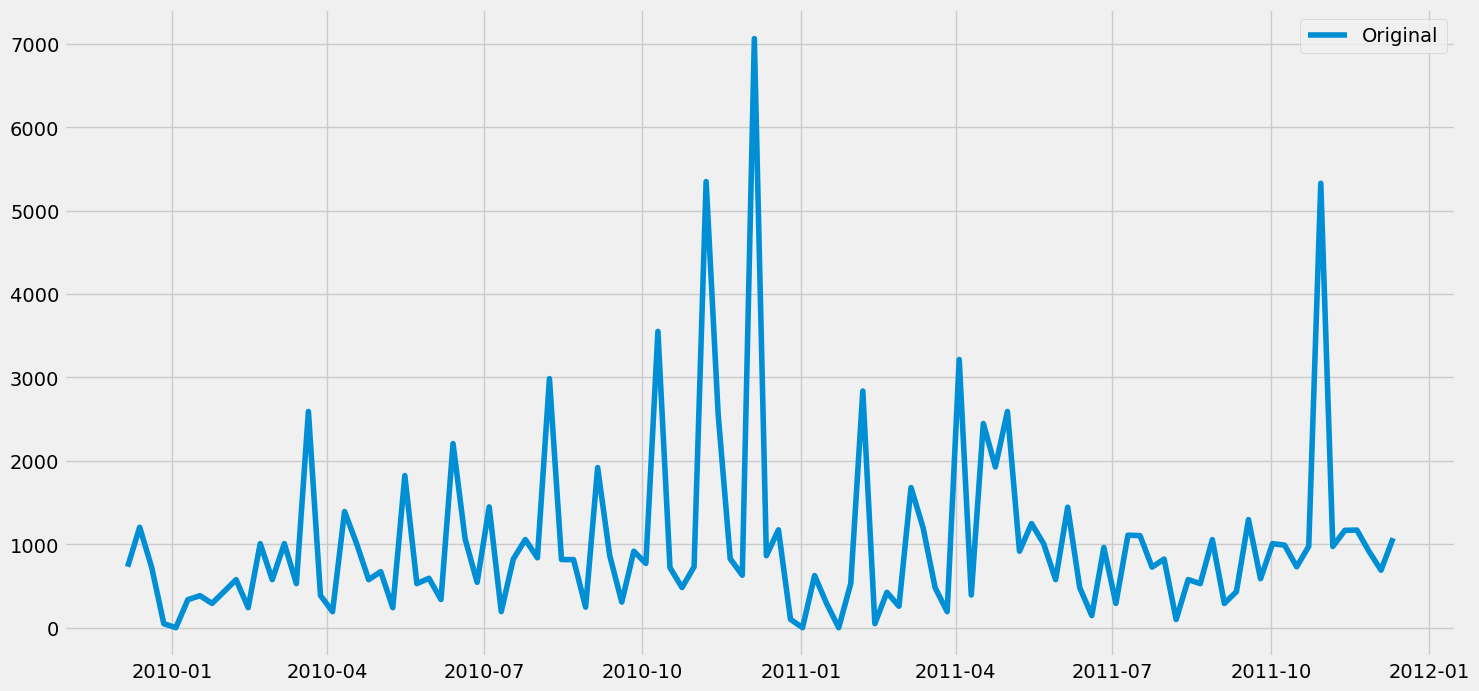

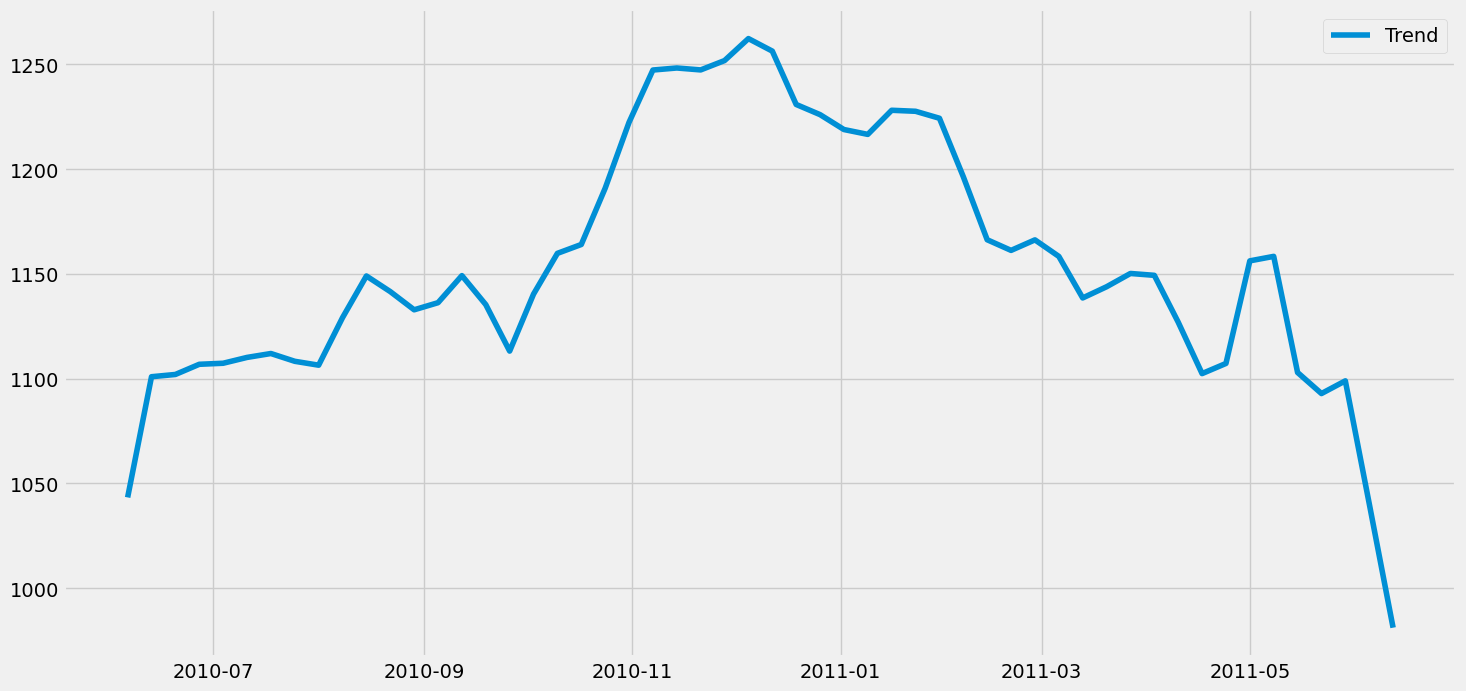

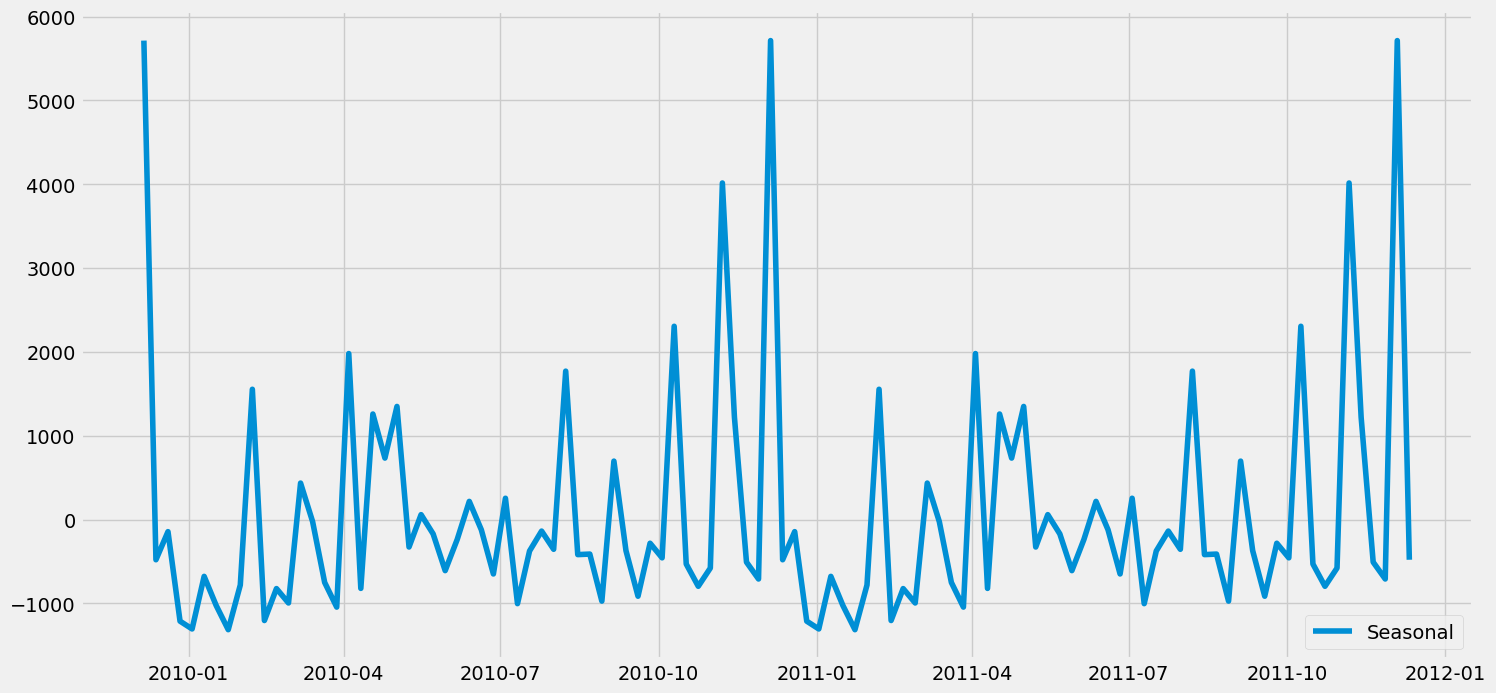

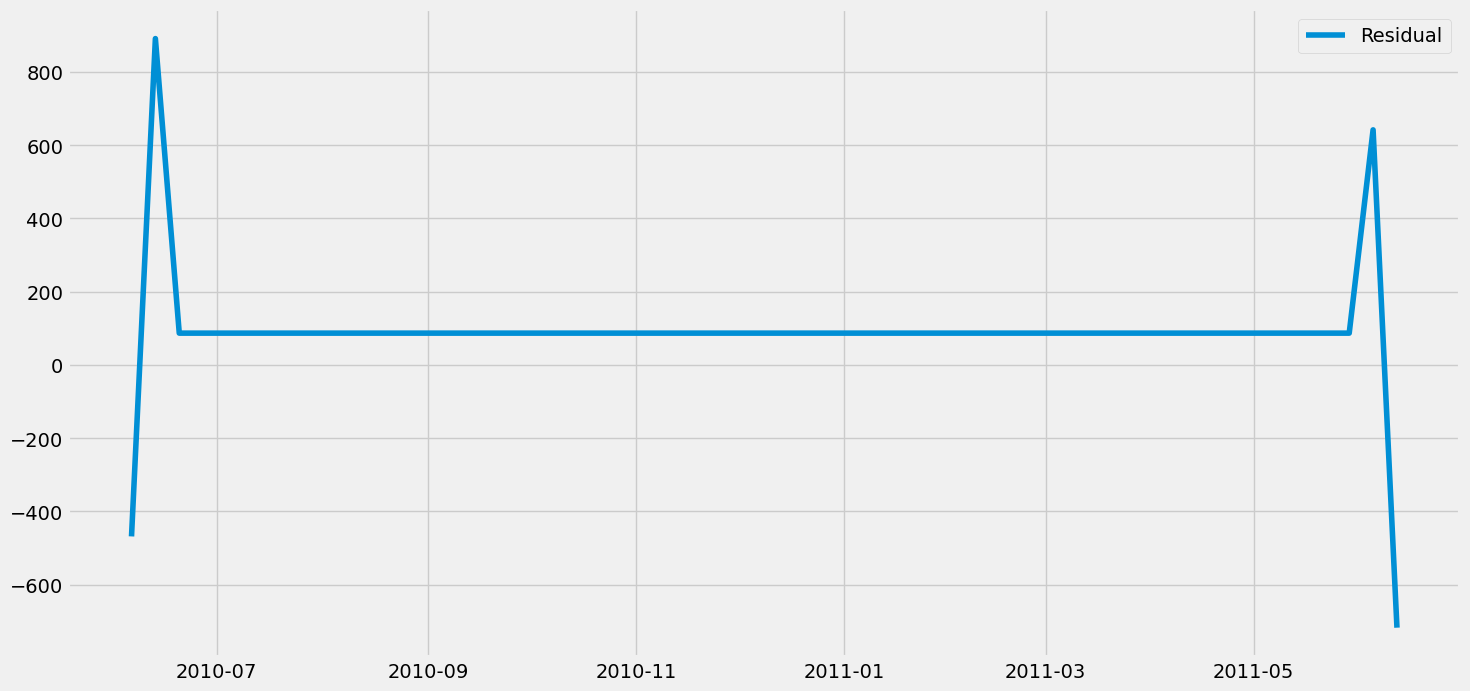

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y)

plt.plot(y, label = 'Original')
plt.legend(loc = 'best')

trend = decomposition.trend
plt.show()
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

seasonal = decomposition.seasonal
plt.show()
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

residual = decomposition.resid
plt.show()
plt.plot(residual, label = 'Residual')
plt.legend(loc='best')

## Checking Stationarity

Our first step in time-series analysis should be to check whether there is any evidence of a trend or seasonal effects and, if there is, remove them. Augmented Dickey-Fuller(ADF) statistics is one of the more widely used statistical test to check whether your time series is stationary or non-stationary. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

**Null Hypothesis: The series has a unit root (value of a =1)(not stationary)**

**Alternate Hypothesis: The series has no unit root (stationary)**

In [43]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.481265
p-value: 0.008481
Critical Values:
	1%: -3.496
	5%: -2.890
	10%: -2.582


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                    <b>The p-value is 0.00481, which is way below the threshold (0.05). Hence the null-hypothesis is rejected. It suggests the time series does not have a unit root, meaning it is stationary.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

# Time Series Forcasting using ARIMA

In [44]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

#pdq            seasonal_pdq 
# 0 0 0         0 0 0 52
# 0 0 1         0 0 1 52  
# 0 1 0         0 1 0 52
# 0 1 1         0 1 1 52
# 1 0 0         1 0 0 52
# 1 0 1         1 0 1 52 
# 1 1 0         1 1 0 52 
# 1 1 1         1 1 1 52

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 0, 0, 52)


## Parameter Selection

In [45]:
from pylab import rcParams
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:          
            continue
#Invertibility refers to linear stationary process which behaves like infinite representation of autoregressive. In other word,
#this is the property that possessed by a moving average process.

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:1838.689736467134
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:906.8704171117947
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:936.4464273107446
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:20.85392065015281
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:948.086766434735
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:908.8691515787177
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:27.85293157655626
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:22.844364014042096
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:1808.9919179073481
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:888.7029748542944
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:920.4947190811804
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:949.1548746828832
ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:882.2909650003104
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:29.46344886390807
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:1827.7517491242406
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:894.636493391674
ARIMA(0, 1, 0)x(0, 1, 0, 52)52 - AIC:

In [46]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -1.0001      0.128     -7.796      0.000      -1.252      -0.749
sigma2      2.694e+06   4.76e-08   5.66e+13      0.000    2.69e+06    2.69e+06


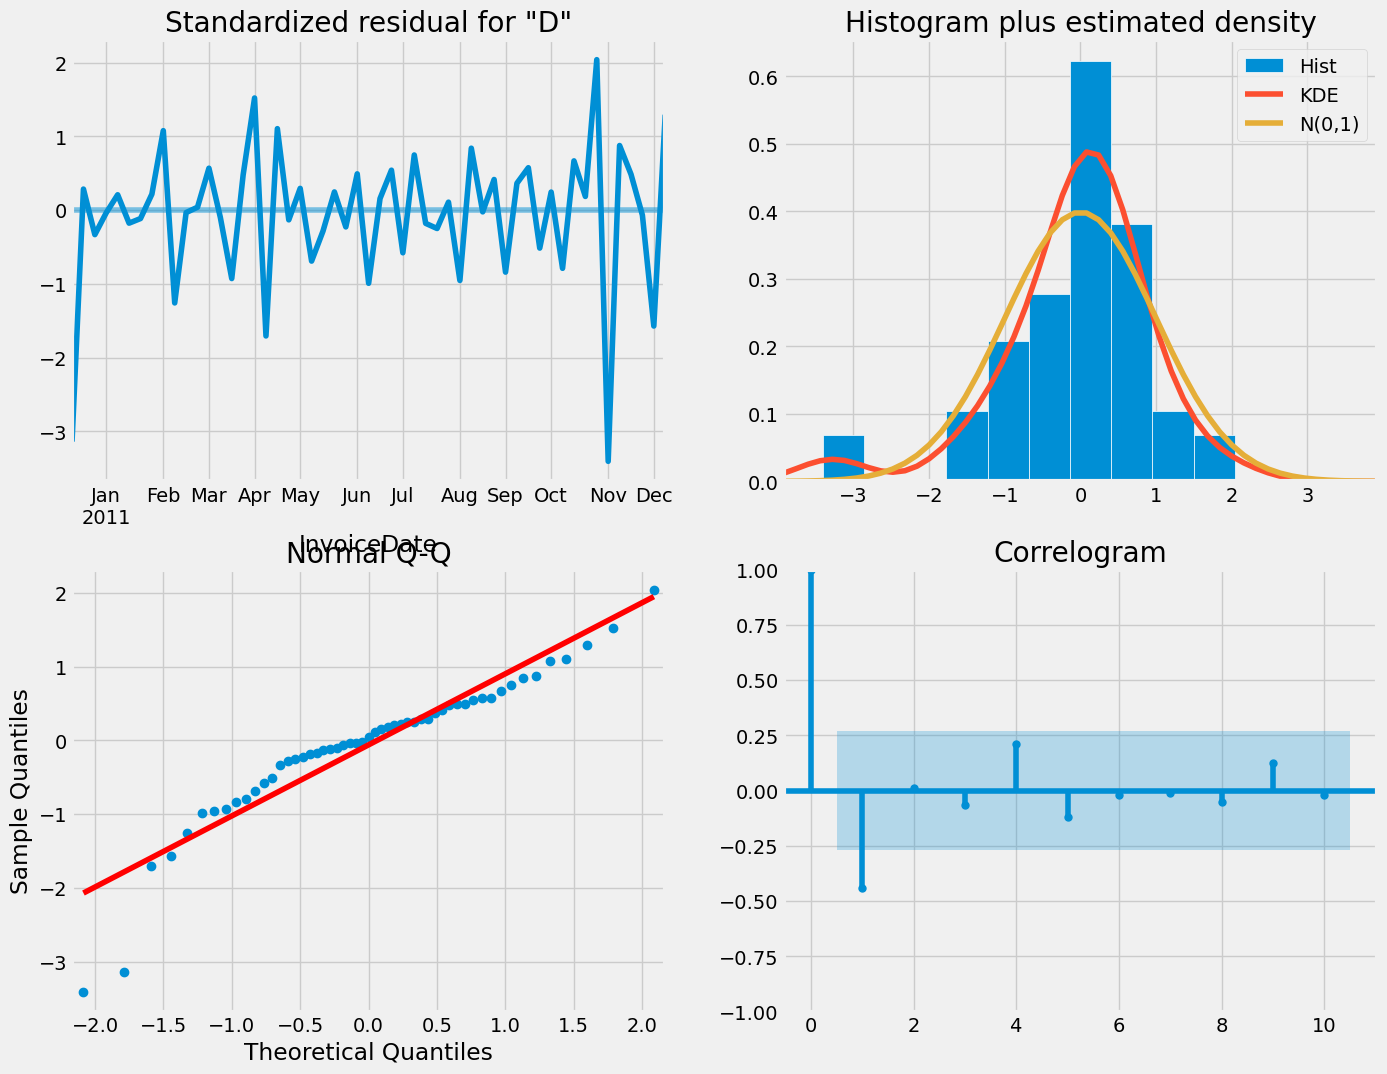

In [47]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Validating Forecasts

In [48]:
#we will use last 20 percent data for validation 
validation_start_index=int(len(y)*0.80)
validation_start_date=y.index[validation_start_index]
print("Starting validation from:", validation_start_date)

Starting validation from: 2011-07-17 00:00:00


In [49]:
pred = results.get_prediction(start=pd.to_datetime(validation_start_date), dynamic=False)
pred_ci = pred.conf_int()

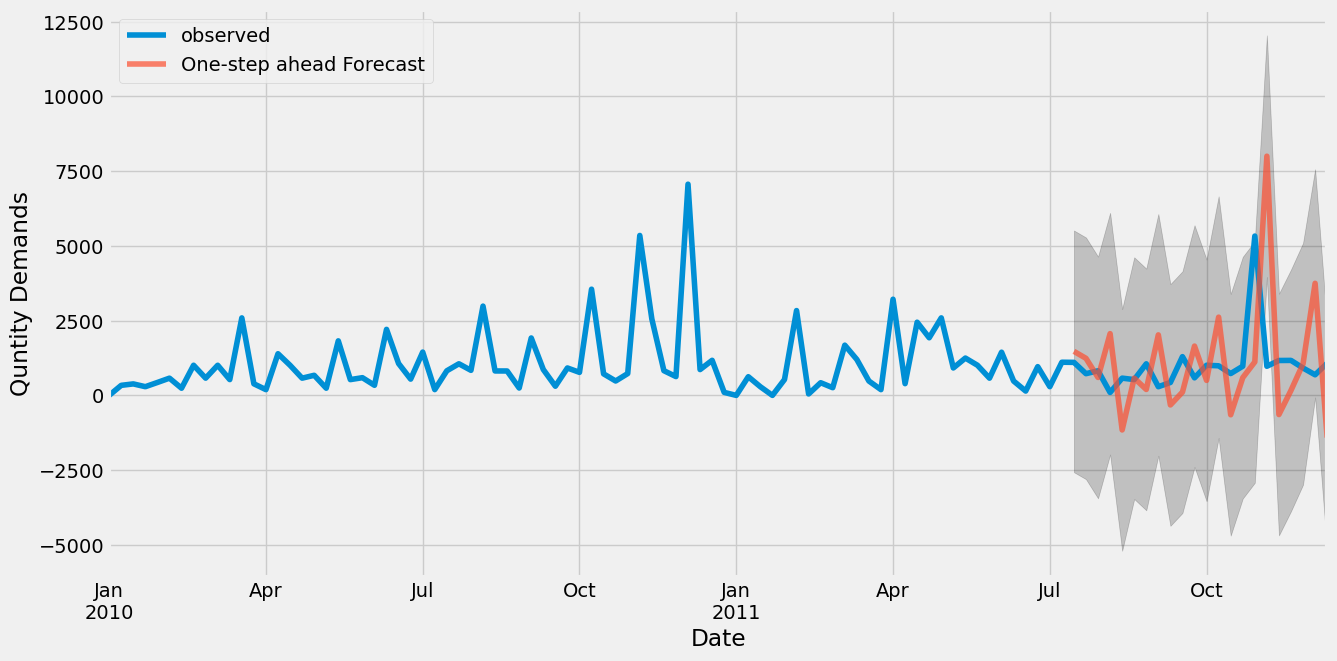

In [50]:
ax = y['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Quntity Demands')
plt.legend()
plt.show()


In [51]:
y_forecasted = pred.predicted_mean
y_truth = y[validation_start_date:]

sarm_model_mae = (y_forecasted - y_truth).abs().mean()
print('The Mean Absolute Error (MAE) is: {}'.format(round(sarm_model_mae, 2)))

sarm_model_mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Sqaured Error (MSE) is: {}'.format(round(sarm_model_mse, 2)))

sarm_model_rmse=np.sqrt(sarm_model_mse)
print('The Root Mean Squared Error (RMSE) is: {}'.format(round(sarm_model_rmse, 2)))

The Mean Absolute Error (MAE) is: 1548.7
The Mean Sqaured Error (MSE) is: 4818594.58
The Root Mean Squared Error (RMSE) is: 2195.13


In [52]:
sarm_model_metrics=pd.Series({'Model':'ARIMA',
                         'MAE':sarm_model_mae,
                         'MSE':sarm_model_mse,
                         'RMSE':sarm_model_rmse
                         })

result_tabulation=result_tabulation._append(sarm_model_metrics,ignore_index=True)

result_tabulation

,Model,MAE,MSE,RMSE
0,Random Forest,1147.702178,1.718893e+06,1311.065683
1,ARIMA,1548.703034,4.818595e+06,2195.129741


# MODEL 3 - LSTM

In [53]:
x_train_lstm=x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test_lstm=x_test.reshape(x_test.shape[0],1,x_test.shape[1])

In [54]:
print("Training Samples:",len(x_train_lstm))
print("Testing Samples:",len(x_test_lstm))

Training Samples: 81
Testing Samples: 21


In [55]:
lstm_model=tf.keras.Sequential([
    tf.keras.layers.LSTM(64,return_sequences=True,input_shape=(1,look_back)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64,return_sequences=False,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [56]:
lstm_model.compile(optimizer='adam',
                  loss='mse')

In [57]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=4, 
                           restore_best_weights=True,
                           verbose=1)
lstm_model.fit(x_train_lstm,y_train,
               epochs=50,
               batch_size=4,
               verbose=1,
              callbacks=[early_stop])

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0428
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0256 
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259 
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244 
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244 
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233 
Epoch

In [58]:
lstm_pred_scaled=lstm_model.predict(x_test_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


In [59]:
#as the predicted value is between 0 and 1 becasue data is scaled we must convert prediction back to actual test data.
lstm_pred_real=scaler.inverse_transform(lstm_pred_scaled)
y_test_real=scaler.inverse_transform(y_test.reshape(-1,1))

In [60]:
lstm_model_MAE=mean_absolute_error(y_test_real,lstm_pred_real)
print('Mean Absolute Error (MAE):',lstm_model_MAE)
lstm_model_MSE=mean_squared_error(y_test_real,lstm_pred_real)
print('Mean Squared Erroe (MSE):',lstm_model_MSE)

lstm_model_RMSE=np.sqrt(mean_squared_error(y_test_real,lstm_pred_real))
print('Root Mean Squared Error (RMSE):',lstm_model_RMSE)

Mean Absolute Error (MAE): 564.6622459774926
Mean Squared Erroe (MSE): 1142874.3893444887
Root Mean Squared Error (RMSE): 1069.053033925113


In [61]:
lstm_model_metrics=pd.Series({'Model':'LSTM',
                         'MAE':lstm_model_MAE,
                         'MSE':lstm_model_MSE,
                         'RMSE':lstm_model_RMSE
                         })

result_tabulation=result_tabulation._append(lstm_model_metrics,ignore_index=True)

result_tabulation

,Model,MAE,MSE,RMSE
0,Random Forest,1147.702178,1.718893e+06,1311.065683
1,ARIMA,1548.703034,4.818595e+06,2195.129741
2,LSTM,564.662246,1.142874e+06,1069.053034



INVENTORY DEMAND FORECASTING SYSTEM

------------------------------


Enter StockCode (or type 'exit'):  84077



✅ Product Identified: WORLD WAR 2 GLIDERS ASSTD DESIGNS
   ID: 84077

------------------------------------------------
Historical Avg Weekly Sales: 1039 units
PREDICTED DEMAND (Next Week): 1057 units
------------------------------------------------
ACTION: Standard Replenishment.


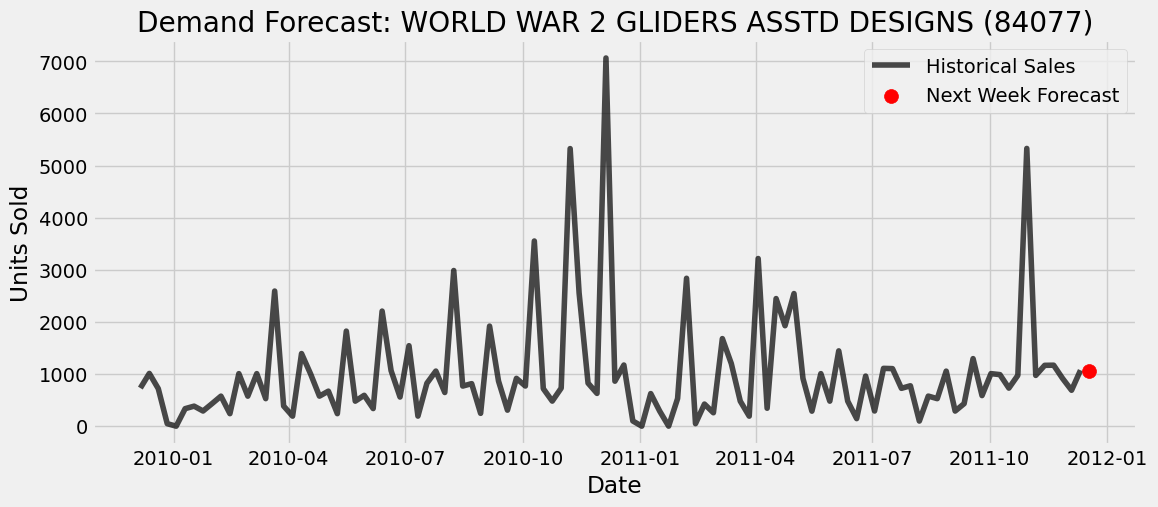


------------------------------


Enter StockCode (or type 'exit'):  exit


👋 Exiting System.


In [62]:

print("\n" + "="*40)
print("INVENTORY DEMAND FORECASTING SYSTEM")
print("="*40)

def predict_by_stockcode(stock_code):
    
    # 1. VALIDATE STOCK CODE
    # Ensure the code exists in our database
    if stock_code not in df['StockCode'].unique():
        print(f"Error: StockCode '{stock_code}' not found in the dataset.")
        print("Please check the ID and try again.")
        return

    # Get the Product Name just for display (so the user knows what they picked)
    product_name = df[df['StockCode'] == stock_code]['Description'].iloc[0]
    print(f"\n✅ Product Identified: {product_name}")
    print(f"   ID: {stock_code}")

    # 2. PREPARE DATA
    # Filter for this specific stock code
    product_data = df[df['StockCode'] == stock_code].copy()
    
    # Resample to Weekly Demand (The crucial step)
    ts_data = pd.DataFrame(product_data.set_index('InvoiceDate')['Quantity'].resample('W').sum().fillna(0))
    ts_data.columns = ['Demand']
    
    # Check for sufficient data
    if len(ts_data) < 10:
        print("Insufficient Data: This product has less than 10 weeks of history.")
        print("Cannot generate a reliable forecast.")
        return

    # 3. FEATURE ENGINEERING
    # Create the "Lag" features (Past 4 weeks) required by the model
    df_rf = ts_data.copy()
    look_back = 4
    for i in range(1, look_back + 1):
        df_rf[f'Lag_{i}'] = df_rf['Demand'].shift(i)
    
    df_rf.dropna(inplace=True)
    
    # Define Features (X) and Target (y)
    X = df_rf.drop('Demand', axis=1)
    y = df_rf['Demand']
    
    # 4. TRAIN MODEL (On the Fly)
    # Random Forest is used here because it's fast and robust for single-item training
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # 5. PREDICT NEXT WEEK
    # We take the very last 4 weeks of data to predict the "Next Unknown Week"
    last_known_window = y.iloc[-look_back:].values.reshape(1, -1)
    next_week_pred = model.predict(last_known_window)
    
    # 6. OUTPUT RESULTS
    avg_sales = int(y.mean())
    predicted_sales = int(next_week_pred[0])
    
    print("\n------------------------------------------------")
    print(f"Historical Avg Weekly Sales: {avg_sales} units")
    print(f"PREDICTED DEMAND (Next Week): {predicted_sales} units")
    print("------------------------------------------------")
    
    # Recommendation Logic
    if predicted_sales > avg_sales * 1.5:
        print("ACTION: High Demand Expected! Increase Stock.")
    elif predicted_sales < avg_sales * 0.5:
        print("ACTION: Low Demand Expected. Hold Stock.")
    else:
        print("ACTION: Standard Replenishment.")

    # 7. PLOT
    plt.figure(figsize=(12, 5))
    plt.plot(ts_data.index, ts_data['Demand'], label='Historical Sales', color='black', alpha=0.7)
    # Add the forecast point at the end
    last_date = ts_data.index[-1]
    next_date = last_date + pd.Timedelta(weeks=1)
    plt.scatter(next_date, predicted_sales, color='red', s=100, label='Next Week Forecast', zorder=5)
    
    plt.title(f"Demand Forecast: {product_name} ({stock_code})")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.show()

# --- MAIN INTERACTIVE LOOP ---
while True:
    print("\n" + "-"*30)
    user_input = input("Enter StockCode (or type 'exit'): ").strip()
    
    if user_input.lower() == 'exit':
        print("👋 Exiting System.")
        break
        
    predict_by_stockcode(user_input)